In [1]:
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('stockmarket.csv')
df.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


In [3]:
import datetime
import calendar

def Date_trans(row):
    temp = row["Date"].split("-")
    temp[1] = list(calendar.month_abbr).index(temp[1])
    y = "-".join('%s' %id for id in temp)
    y = datetime.datetime.strptime(y, '%d-%m-%Y')
    return y

df["Date_T"] = df.apply (Date_trans , axis = 1)    

In [4]:
def Train_Test(row):
    y = row["Date_T"].year
    if y < 2018:
        return "T"
    else:
        return "F"

df["Train"] = df.apply (Train_Test , axis = 1)    

In [5]:
df['Train'].value_counts()

T    2264
F     252
Name: Train, dtype: int64

In [6]:
def ToStamp(row):
    y = datetime.datetime.timestamp(row["Date_T"])
    return y

df["Time"] = df.apply (ToStamp , axis = 1) 

In [7]:
def Rise_Fall_P(row):
    P = (row["Close Price"]/row["Open Price"]-1)*100
    if P > 0:
        return "0" #rise
    elif P < 0:
        return "1" #fall
    else:
        return "2" #same
    return P

df["Diff"] = df.apply (Rise_Fall_P , axis = 1)

In [8]:
df.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,Date_T,Train,Time,Diff
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080,2009-01-02,T,1.230826e+09,0
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016,2009-01-05,T,1.231085e+09,1
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032,2009-01-06,T,1.231171e+09,0
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032,2009-01-07,T,1.231258e+09,1
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952,2009-01-08,T,1.231344e+09,0


In [9]:
Data = df.drop(["Date", "Close Price", "Date_T"], axis=1)
Data_train = Data[Data["Train"] == "T"].drop(["Train"], axis=1)
Data_test = Data[Data["Train"] == "F"].drop(["Train"], axis=1)

In [10]:
x_train = Data_train.loc[:, Data_train.columns != "Diff"]
y_train = Data_train["Diff"]
x_test = Data_test.loc[:, Data_test.columns != "Diff"]
y_test = Data_test["Diff"]

In [11]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

In [12]:
hidden_units = 10    
activation = 'relu'  
l2 = 0.           
learning_rate = 0.1 
epochs = 20          
batch_size = 32      

In [13]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=5,
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
df['Diff'].value_counts()
#y_train.shape

0    1362
1    1152
2       2
Name: Diff, dtype: int64

In [15]:
class_weight = {
    "0": 1.,
    "1": 1152 / 1362,
    "2": 2/1362
}

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2264/2264 [==============================] - ETA: 30s - loss: 0.6264 - acc: 0.56 - ETA: 0s - loss: 0.6448 - acc: 0.5234 - ETA: 0s - loss: 0.6367 - acc: 0.546 - 1s 259us/step - loss: 0.6372 - acc: 0.5424
Epoch 2/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6441 - acc: 0.468 - ETA: 0s - loss: 0.6399 - acc: 0.505 - ETA: 0s - loss: 0.6362 - acc: 0.528 - ETA: 0s - loss: 0.6309 - acc: 0.547 - 0s 84us/step - loss: 0.6312 - acc: 0.5464
Epoch 3/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6038 - acc: 0.656 - ETA: 0s - loss: 0.6335 - acc: 0.542 - ETA: 0s - loss: 0.6322 - acc: 0.548 - 0s 74us/step - loss: 0.6319 - acc: 0.5455
Epoch 4/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6555 - acc: 0.437 - ETA: 0s - loss: 0.6330 - acc: 0.536 - ETA: 0s - loss: 0.6317 - acc: 0.542 - ETA: 0s - loss: 0.6313 - acc: 0.547 - 0s 78us/step - loss: 0.6317 - acc: 0.5455
Epoch 5/10
2264/2264 [====

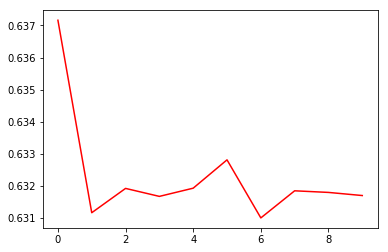

In [16]:
# train the parameters
history = model.fit(x_train, y_train, epochs=10, batch_size=batch_size, class_weight=class_weight)

# evaluate accuracy
train_acc = model.evaluate(x_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(x_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [17]:
def train_and_evaluate(model, x_train, y_train, x_test, y_test, n=20):
    train_accs = []
    test_accs = []
    with tqdm(total=n) as progress_bar:
        for _ in range(n):
            model.fit(
                x_train, 
                y_train, 
                epochs=epochs, 
                batch_size=batch_size, 
                class_weight=class_weight, 
                verbose=False)
            train_accs.append(model.evaluate(x_train, y_train, batch_size=32, verbose=False)[1])
            test_accs.append(model.evaluate(x_test, y_test, batch_size=32, verbose=False)[1])
            progress_bar.update()
    print('Avgerage Training Accuracy: %s' % np.average(train_accs))
    print('Avgerage Testing Accuracy: %s' % np.average(test_accs))
    return train_accs, test_accs

In [18]:
_, test_accs = train_and_evaluate(model, x_train, y_train, x_test, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:45<00:00,  2.18s/it]


Avgerage Training Accuracy: 0.5454946998572601
Avgerage Testing Accuracy: 0.5039682549143596


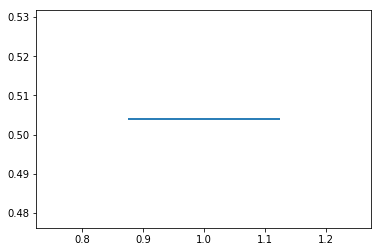

In [19]:
plt.violinplot(test_accs)
plt.show()

In [20]:
print('Min: %s' % np.min(test_accs))
print('Max: %s' % np.max(test_accs))

Min: 0.5039682549143595
Max: 0.5039682549143595


In [21]:
hidden_units = 10    
activation = 'sigmoid' 
l2 = 0.              
learning_rate = 0.1 
epochs = 20          
batch_size = 32      

In [22]:
def build_model(hidden_units, activation, learning_rate):
    model = models.Sequential()
    model.add(layers.Dense(input_dim=5,
                           units=hidden_units, 
                           activation=activation,
                           kernel_regularizer=regularizers.l2(l2)))
    model.add(layers.Dense(input_dim=hidden_units,
                           units=1,
                           activation='relu',
                           kernel_regularizer=regularizers.l2(l2)))
    model.compile(loss='binary_crossentropy',
                  # Adam is a kind of gradient descent
                  optimizer=optimizers.Adam(lr=learning_rate),
                  metrics=['accuracy'])
    return model

model = build_model(hidden_units, activation, learning_rate)

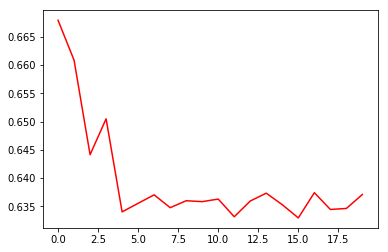

In [23]:
history = model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size, 
    class_weight=class_weight, verbose=False)
losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [24]:
_, __ = train_and_evaluate(model, x_train, y_train, x_test, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.38s/it]


Avgerage Training Accuracy: 0.536417844717789
Avgerage Testing Accuracy: 0.502976191233075
